In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from pprint import pprint
import tensorflow as tf
import tensorflow.contrib.slim as slim
import vgg

In [2]:
height = 224
width = 224
channels = 3

In [3]:
# The input to the graph
input_var_0 = np.random.rand(1, height, width, channels)
input_var = tf.Variable(input_var_0, dtype=tf.float32, name='input_var')

# Load the vgg model
with slim.arg_scope(vgg.vgg_arg_scope()):
    logits, end_points = vgg.vgg_19(input_var, num_classes=1000, is_training=False)
    #predictions = end_points['vgg_19/conv1/conv1_2']

In [4]:
# Prepare to restore the vgg19 nodes
# Skip trying to restore the input variable since it's new
all_variables = tf.get_collection_ref(tf.GraphKeys.GLOBAL_VARIABLES)
saver = tf.train.Saver(var_list=all_variables[1:])

In [5]:
# Construct the real image tensor
# And the operation which assigns it to input_var
real_image = cv2.imread('./coastal_scene.jpg')
real_image = cv2.resize(real_image, (height, width))
real_image = cv2.cvtColor(real_image, cv2.COLOR_BGR2RGB)
real_image_batch = np.expand_dims(real_image, axis=0)
real_image_batch = np.asarray(real_image_batch, dtype=np.float32)
real_image_tensor = tf.Variable(real_image_batch, dtype=tf.float32, name='real_image')

assign_real_image = tf.assign(input_var, real_image_tensor, name='assign_real_image')

# Construct the white noise tensor
# And the operation which assigns it to input_var
white_noise = np.random.rand(height, width, channels) * 255.
white_noise_batch = np.expand_dims(white_noise, axis=0)
white_noise_batch = np.asarray(white_noise_batch, dtype=np.float32)
white_noise_tensor = tf.Variable(white_noise_batch, dtype=tf.float32, name='white_noise')

assign_white_noise = tf.assign(input_var, white_noise_tensor, name='assign_white_noise')

INFO:tensorflow:Restoring parameters from ./vgg_19.ckpt
loss: 179.90272521972656
diff: 0.0
loss: -28.704605102539062
diff: -799006.375
loss: -24.218673706054688
diff: -697711.25
loss: -20.518638610839844
diff: -611727.5625
loss: -17.435455322265625
diff: -539026.625
loss: -14.807632446289062
diff: -476384.8125
loss: -12.552608489990234
diff: -421395.875
loss: -10.621574401855469
diff: -372614.8125
loss: -8.966766357421875
diff: -329419.875
loss: -7.537906646728516
diff: -292823.96875
loss: -6.32005500793457
diff: -258993.015625
loss: -5.279623031616211
diff: -229336.8125
loss: -4.389768600463867
diff: -202925.96875
loss: -3.631545066833496
diff: -179554.75
loss: -2.9908456802368164
diff: -158569.890625
loss: -2.449070930480957
diff: -139959.359375
loss: -1.9921989440917969
diff: -123068.46875
loss: -1.6084070205688477
diff: -107727.734375
loss: -1.2910361289978027
diff: -94019.3203125
loss: -1.0289976596832275
diff: -81693.921875
loss: -0.8136868476867676
diff: -70773.828125
loss: -0.6

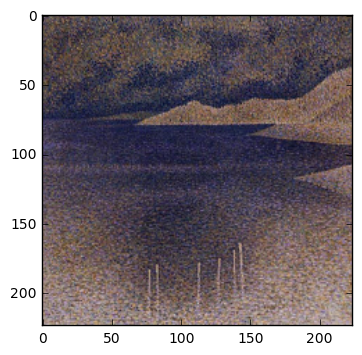

In [6]:
predictions = end_points['vgg_19/conv1/conv1_2']

batch_size_res, height_res, width_res, channels_res = np.shape(predictions)

# This placeholder will hold the response from the layer we are interested in
# given the real image
desired_response = tf.placeholder(tf.float32, 
                                  shape=[batch_size_res, height_res, width_res, channels_res],
                                 name='desired_response')

loss = tf.losses.mean_squared_error(labels=desired_response, predictions=predictions)
optimizer = tf.train.AdamOptimizer(1e-1)
train_op = optimizer.minimize(loss, var_list=[input_var])

loss_summary = tf.summary.scalar('loss', loss)
image_summary = tf.summary.image('image', input_var)
merged_summary = tf.summary.merge_all()


init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer(),
                  name='initialize_all')

with tf.Session() as sess:
    
    
    saver.restore(sess, './vgg_19.ckpt')
    sess.run(init_op)
    
    train_writer = tf.summary.FileWriter('./train', sess.graph)
        
    # Using the real image, get the response of the chosen layer
    assign_real_image.eval()
    input_var_ = input_var.eval()
    input_var_ = np.squeeze(input_var_, axis=0)
    cv2.imwrite('real.jpg', input_var_)
    
    desired_response_ = predictions.eval()
#     print(desired_response_)
    
    # Assign the white noise to the image
    assign_white_noise.eval()
    input_var_ = input_var.eval()
    input_var_0 = np.squeeze(input_var_, axis=0)
    #cv2.imwrite('white.jpg', input_var_)
    
    current_response_ = predictions.eval()
#     print(current_response_)
    loss_0 = 0
    # Begin training
    for i in range(10000):
        input_var_, summary, loss_, _ = sess.run([input_var, merged_summary, loss, train_op], 
                                     feed_dict={desired_response:desired_response_})
        train_writer.add_summary(summary, i)
        if i%100==0:
            print('loss: {}'.format(loss_-loss_0))
            diff = np.sum(input_var_0-input_var_)
            print('diff: {}'.format(diff))
            input_var_0 = input_var_
            loss_0 = loss_
    
    input_var_ = input_var.eval()
    input_var_ = np.squeeze(input_var_, axis=0)
    plt.figure()
    plt.imshow(input_var_)
    
    